In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model

In [2]:
def preprocess_image_pair(gray_path, color_path):
    """
    Đọc và xử lý một cặp ảnh grayscale và ảnh màu từ đường dẫn file.

    Args:
        gray_path: Đường dẫn ảnh trắng đen
        color_path: Đường dẫn ảnh màu

    Returns:
        Tuple (grayscale_tensor, color_tensor) đã resize và normalize.
    """
    # Load ảnh trắng đen
    gray_image = tf.io.read_file(gray_path)
    gray_image = tf.image.decode_jpeg(gray_image, channels=1)
    gray_image = tf.image.resize(gray_image, [256, 256])
    gray_image = gray_image / 255.0

    # Load ảnh màu
    color_image = tf.io.read_file(color_path)
    color_image = tf.image.decode_jpeg(color_image, channels=3)
    color_image = tf.image.resize(color_image, [256, 256])
    color_image = color_image / 255.0

    return gray_image, color_image


In [3]:
def prepare_landscape_dataset(color_folder, gray_folder, batch_size=64, train_count=5600):
    """
    Tạo tf.data.Dataset từ thư mục chứa ảnh màu và trắng đen.

    Args:
        color_folder: Thư mục chứa ảnh màu
        gray_folder: Thư mục chứa ảnh trắng đen
        batch_size: Kích thước mỗi batch
        train_count: Số lượng ảnh dùng cho training

    Returns:
        Tuple (train_ds, val_ds, test_ds)
    """
    color_images = sorted([
        os.path.join(color_folder, fname) for fname in os.listdir(color_folder)
        if fname.lower().endswith(".jpg")
    ])
    gray_images = sorted([
        os.path.join(gray_folder, fname) for fname in os.listdir(gray_folder)
        if fname.lower().endswith(".jpg")
    ])

    assert len(color_images) == len(gray_images), "Số lượng ảnh trắng đen và màu không khớp"
    total_images = len(color_images)

    # Ghép cặp ảnh và xử lý
    dataset = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(gray_images),
        tf.data.Dataset.from_tensor_slices(color_images)
    ))
    dataset = dataset.map(preprocess_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(total_images)

    # Chia tập
    train_ds = dataset.take(train_count).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    remaining = dataset.skip(train_count)
    val_size = (total_images - train_count) // 2
    val_ds = remaining.take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = remaining.skip(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds


In [ ]:
color_path = "D:/ColorizationImage/source/landscape Images/color"
gray_path = "D:/ColorizationImage/source/landscape Images/gray"

train_ds, val_ds, test_ds = prepare_landscape_dataset(color_path, gray_path)


In [5]:
def plot_image_pairs(dataset, num_pairs=5):
    # Unbatch the dataset to get individual image pairs
    unbatched_ds = dataset.unbatch()

    # Take the specified number of pairs
    data_iterator = unbatched_ds.take(num_pairs).as_numpy_iterator()

    plt.figure(figsize=(15, 5 * (num_pairs // 5 + 1)))  # Adjust figure size

    for i, (gray, color) in enumerate(data_iterator):
        plt.subplot(num_pairs // 5 + 1, 5, i + 1)
        plt.imshow(gray.squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
        plt.title(f'Grayscale Input {i+1}')
        plt.axis('off')

        plt.subplot(num_pairs // 5 + 1, 5, i + 1 + num_pairs)
        plt.imshow(color)
        plt.title(f'Color Output {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Training Set Samples:


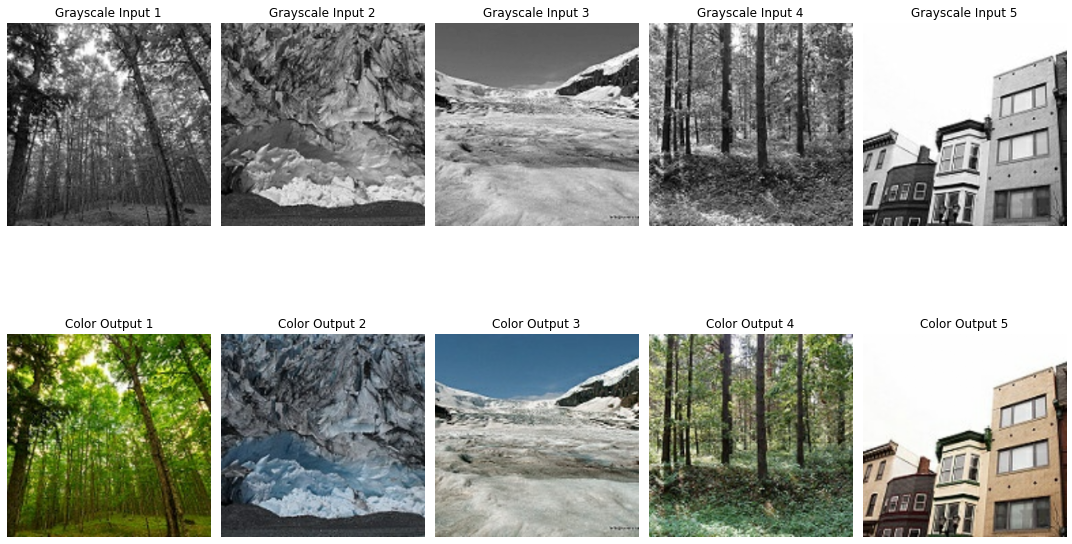

Validation Set Samples:


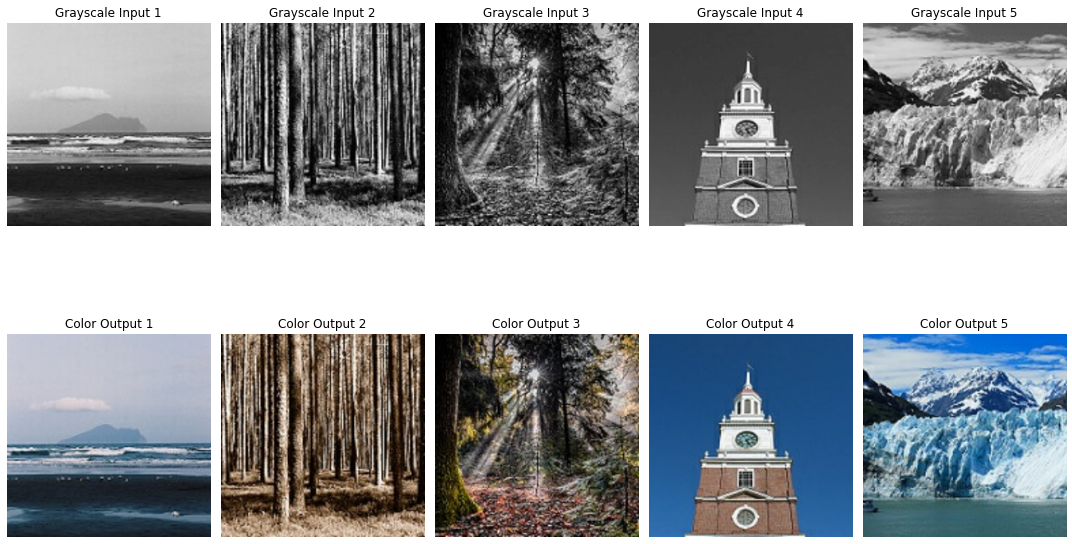

Test Set Samples:


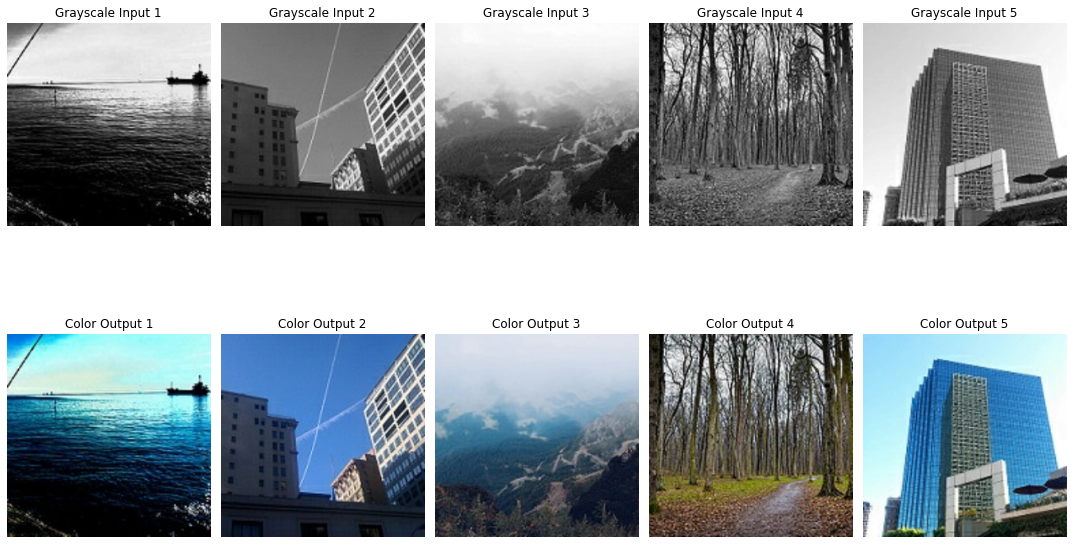

In [6]:
# Plot 5 pairs from each set to validate
print("Training Set Samples:")
plot_image_pairs(train_ds, num_pairs=5)

print("Validation Set Samples:")
plot_image_pairs(val_ds, num_pairs=5)

print("Test Set Samples:")
plot_image_pairs(test_ds, num_pairs=5)

In [7]:
def downsample(filters, size, apply_batchnorm=True):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',
                                    kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [8]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=[None, None, 1]) 

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), 
        downsample(128, 4), 
        downsample(256, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4),  
        upsample(256, 4),  
        upsample(128, 4),  
        upsample(64, 4),  
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh') 

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name='U_net_generator')

In [9]:
generator = build_generator()
generator.summary()

Model: "U_net_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   1024        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131584      ['sequential[0][0]']             
                                128)                                                

In [11]:
discriminator = build_discriminator()
discriminator.summary()

Model: "PatchGAN_Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 target_image (InputLayer)      [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 concatenate_7 (Concatenate)    (None, None, None,   0           ['input_image[0][0]',            
                                4)                                'target_ima

In [14]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  adv_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = adv_loss + (LAMBDA * l1_loss)
  return total_gen_loss, adv_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [23]:
GENERATOR_LR_INIT = 2e-4
DISCRIMINATOR_LR_INIT = 2e-4
ADAM_BETA_1 = 0.5
SAVE_DIR = 'gan_checkpoints_minimal'
EARLY_STOPPING_MONITOR = 'val_gen_l1_loss'

In [24]:

def train_pix2pixgan(
    train_ds,
    epochs,
    validation_ds=None,
    generator_in=None,
    discriminator_in=None,
    early_stopping_patience=None,
    lr_decay_patience=None,
    lr_decay_factor=0.5,
    min_lr=1e-7
):
   
    print("--- Pix2PixGAN Training Setup ---")
    generator = build_generator() if generator_in is None else generator_in
    discriminator = build_discriminator() if discriminator_in is None else discriminator_in
    print(f"Using {'new' if generator_in is None else 'provided'} generator, "
          f"{'new' if discriminator_in is None else 'provided'} discriminator.")
    generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR_INIT, beta_1=ADAM_BETA_1)
    discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR_INIT, beta_1=ADAM_BETA_1)
    print(f"Optimizers: Adam (Initial Gen LR={GENERATOR_LR_INIT:.1e}, "
          f"Initial Disc LR={DISCRIMINATOR_LR_INIT:.1e}, Beta1={ADAM_BETA_1})")
    metric_key_to_monitor = EARLY_STOPPING_MONITOR
    perform_validation = validation_ds is not None

    if perform_validation and metric_key_to_monitor == 'val_disc_loss':
         print(f"Warning: Monitoring 'val_disc_loss' is disabled. Defaulting to 'val_l1_loss'.")
         metric_key_to_monitor = 'val_l1_loss' 

    perform_early_stopping = early_stopping_patience is not None and perform_validation
    perform_lr_decay = lr_decay_patience is not None and perform_validation

    print(f"Saving best models to: {SAVE_DIR}")
    if perform_validation:
        print(f"Monitoring metric for improvements: '{metric_key_to_monitor}'")
    if early_stopping_patience:
        print(f"Early stopping patience: {early_stopping_patience} epochs" if perform_early_stopping else \
              "Early stopping requires validation_ds to be active.")
    if lr_decay_patience:
        print(f"LR decay patience: {lr_decay_patience} epochs (factor={lr_decay_factor}, min_lr={min_lr:.1e})" if perform_lr_decay else \
              "LR decay requires validation_ds to be active.")


    best_gen_weights_path = os.path.join(SAVE_DIR, 'best_generator.weights.h5')
    best_disc_weights_path = os.path.join(SAVE_DIR, 'best_discriminator.weights.h5')
    os.makedirs(SAVE_DIR, exist_ok=True)

    best_metric_value = np.inf 
    epochs_no_improve = 0
    best_epoch = 0

    @tf.function
    def train_step_internal(input_image, target):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
            gen_total_loss, gen_adv_loss, gen_l1_loss = generator_loss(
                disc_generated_output, gen_output, target
            )
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        return gen_adv_loss, gen_l1_loss, disc_loss

    @tf.function
    def validation_step_internal(input_image, target):
        gen_output = generator(input_image, training=False)
        disc_generated_output = discriminator([input_image, gen_output], training=False)
        _, gen_adv_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target
        )
        return gen_adv_loss, gen_l1_loss

    print(f"\n--- Starting Training ({epochs} epochs) ---")
    num_train_batches_total = tf.data.experimental.cardinality(train_ds).numpy()
    if num_train_batches_total in [-1, -2]: 
        print("Training dataset size unknown or infinite, progress bar may lack ETA.")
        num_train_batches_total = None

    training_completed_epochs = 0 
    for epoch in range(epochs):
        start_time = time.time()
        training_completed_epochs = epoch + 1

        epoch_train_metrics = {'gen_adv_loss': 0.0, 'gen_l1_loss': 0.0, 'disc_loss': 0.0}
        progbar = tf.keras.utils.Progbar(num_train_batches_total, stateful_metrics=['epoch','gen_adv_loss', 'gen_l1_loss', 'disc_loss'])
        actual_train_batches = 0
        progbar.update(0, values=[('epoch', epoch + 1)])

        for batch_idx, (input_image, target) in enumerate(train_ds):
            gen_adv_loss, gen_l1_loss, disc_loss = train_step_internal(input_image, target)
            actual_train_batches += 1
            metrics_values = [
                ('epoch', epoch + 1),
                ("gen_adv_loss", float(gen_adv_loss)),
                ("gen_l1_loss", float(gen_l1_loss)),
                ("disc_loss", float(disc_loss))
            ]
            progbar.update(batch_idx + 1, values=metrics_values)
            epoch_train_metrics['gen_adv_loss'] += float(gen_adv_loss)
            epoch_train_metrics['gen_l1_loss'] += float(gen_l1_loss)
            epoch_train_metrics['disc_loss'] += float(disc_loss)

        if actual_train_batches > 0:
            for key in epoch_train_metrics:
                epoch_train_metrics[key] /= actual_train_batches
        else:
             print("Warning: No training batches were processed in this epoch.")

        epoch_val_metrics = {'val_gen_adv_loss': 0.0, 'val_gen_l1_loss': 0.0}
        actual_val_batches = 0
        final_display_metrics = [('epoch', epoch + 1)]
        final_display_metrics.extend([(k, v) for k, v in epoch_train_metrics.items()]) 

        if perform_validation:
            for input_image, target in validation_ds:
                 val_gen_adv_loss, val_gen_l1_loss = validation_step_internal(input_image, target)
                 epoch_val_metrics['val_gen_adv_loss'] += float(val_gen_adv_loss)
                 epoch_val_metrics['val_gen_l1_loss'] += float(val_gen_l1_loss)
                 actual_val_batches += 1

            if actual_val_batches > 0:
                for key in epoch_val_metrics:
                    epoch_val_metrics[key] /= actual_val_batches
            else:
                print("Warning: No validation batches processed.")
                for key in epoch_val_metrics: epoch_val_metrics[key] = None 

            final_display_metrics.extend([(k, v) for k, v in epoch_val_metrics.items()])

        progbar.update(actual_train_batches, values=final_display_metrics, finalize=True)

        current_metric_value = np.inf 

        if perform_validation:
            current_metric_value = epoch_val_metrics.get(metric_key_to_monitor)
            if current_metric_value is None:
                 print(f"Warning: Monitored metric '{metric_key_to_monitor}' value not available this epoch.")
                 current_metric_value = np.inf 

        if current_metric_value < best_metric_value:
            print(f"\n  >> Metric ({metric_key_to_monitor}) improved: {best_metric_value:.4f} -> {current_metric_value:.4f}. Saving models...")
            best_metric_value = current_metric_value
            generator.save_weights(best_gen_weights_path)
            discriminator.save_weights(best_disc_weights_path)
            epochs_no_improve = 0
            best_epoch = epoch + 1
            print() 
        elif perform_validation: 
            epochs_no_improve += 1
            patience_info = []
            if perform_early_stopping: patience_info.append(f"Stop Patience: {epochs_no_improve}/{early_stopping_patience}")
            if perform_lr_decay: patience_info.append(f"LR Decay Patience: {epochs_no_improve % lr_decay_patience if lr_decay_patience > 0 else epochs_no_improve}/{lr_decay_patience}")

            if patience_info:
                 print(f"\n  >> Metric did not improve. ({', '.join(patience_info)})\n")

            if perform_lr_decay and (epochs_no_improve % lr_decay_patience == 0) and epochs_no_improve > 0 :
                current_gen_lr = generator_optimizer.learning_rate.numpy()
                current_disc_lr = discriminator_optimizer.learning_rate.numpy()

                new_gen_lr = max(current_gen_lr * lr_decay_factor, min_lr)
                new_disc_lr = max(current_disc_lr * lr_decay_factor, min_lr)

                lr_updated = False
                if new_gen_lr < current_gen_lr:
                    generator_optimizer.learning_rate.assign(new_gen_lr)
                    lr_updated = True
                if new_disc_lr < current_disc_lr:
                    discriminator_optimizer.learning_rate.assign(new_disc_lr)
                    lr_updated = True

                if lr_updated:
                    print(f"  >> Decaying learning rate after {epochs_no_improve} epochs of no improvement.")
                    print(f"     Gen LR: {current_gen_lr:.1e} -> {generator_optimizer.learning_rate.numpy():.1e}")
                    print(f"     Disc LR: {current_disc_lr:.1e} -> {discriminator_optimizer.learning_rate.numpy():.1e}\n")

        if perform_early_stopping and epochs_no_improve >= early_stopping_patience:
            print(f"-- Early stopping triggered after epoch {epoch + 1} --")
            print(f"   Best metric ({metric_key_to_monitor}): {best_metric_value:.4f} achieved at epoch {best_epoch}.")
            break 

    print(f"\n--- Training Finished ({training_completed_epochs}/{epochs} epochs completed) ---")

    if perform_validation and best_epoch > 0: 
        if os.path.exists(best_gen_weights_path) and os.path.exists(best_disc_weights_path):
            print(f"Loading best weights from epoch {best_epoch} (Metric: {best_metric_value:.4f})...")
            try:
                generator.load_weights(best_gen_weights_path)
                discriminator.load_weights(best_disc_weights_path)
                print("Best weights loaded successfully.")
            except Exception as e:
                print(f"Warning: Error loading best weights from {SAVE_DIR}. Models retain last epoch weights. Error: {e}")
        else:
             print(f"Warning: Best weight files not found at {SAVE_DIR}. Models retain last epoch weights.")
    else:
         
         if training_completed_epochs > 0:
             print("Models retain weights from the last training epoch" +
                   (" (no improvement detected)." if perform_validation and best_epoch == 0 else "."))


    return generator, discriminator

In [25]:
generator, discriminator = train_pix2pixgan(train_ds,200, validation_ds=val_ds, early_stopping_patience=30, lr_decay_patience=5)

--- Pix2PixGAN Training Setup ---
Using new generator, new discriminator.
Optimizers: Adam (Initial Gen LR=2.0e-04, Initial Disc LR=2.0e-04, Beta1=0.5)
Saving best models to: gan_checkpoints_minimal
Monitoring metric for improvements: 'val_gen_l1_loss'
Early stopping patience: 30 epochs
LR decay patience: 5 epochs (factor=0.5, min_lr=1.0e-07)

--- Starting Training (200 epochs) ---
88/88 [==============================] - 77s 766ms/step - epoch: 1.0000 - gen_adv_loss: 0.9137 - gen_l1_loss: 0.1013 - disc_loss: 1.3269 - val_gen_adv_loss: 0.8695 - val_gen_l1_loss: 0.1119

  >> Metric (val_gen_l1_loss) improved: inf -> 0.1119. Saving models...

88/88 [==============================] - 74s 767ms/step - epoch: 2.0000 - gen_adv_loss: 0.9711 - gen_l1_loss: 0.0603 - disc_loss: 1.2042 - val_gen_adv_loss: 0.5972 - val_gen_l1_loss: 0.1607

  >> Metric did not improve. (Stop Patience: 1/30, LR Decay Patience: 1/5)

88/88 [==============================] - 77s 793ms/step - epoch: 3.0000 - gen_adv_lo

In [26]:
def test_generator(
    generator,
    test_dataset,
    num_samples = 3
):

    unbatched_dataset = test_dataset.unbatch()
    sampled_data_list = list(unbatched_dataset.take(num_samples).as_numpy_iterator())
    actual_num_samples = len(sampled_data_list)

    if actual_num_samples == 0:
        print("Error: Could not retrieve any samples from the dataset. "
              "Check if the dataset is empty or if .take() failed.")
        return

    if actual_num_samples < num_samples:
        print(f"Warning: Requested {num_samples} samples, but dataset only yielded {actual_num_samples}.")
        num_samples = actual_num_samples

    grayscale_samples = [item[0] for item in sampled_data_list]
    colored_samples_gt = [item[1] for item in sampled_data_list]
    grayscale_batch = tf.stack([tf.cast(img, tf.float32) for img in grayscale_samples])
    generated_samples_raw = generator(grayscale_batch, training=False)

    generated_samples = tf.cast(generated_samples_raw, tf.float32)
    generated_samples = tf.clip_by_value(generated_samples, 0.0, 1.0)

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 2.5 * num_samples))

    if num_samples == 1:
        axes_flat = [axes]
    else:
        axes_flat = axes

    for i in range(num_samples):
        current_axes = axes_flat[i]

        ax_input = current_axes[0]
        ax_input.imshow(grayscale_samples[i].squeeze(), cmap='gray')
        ax_input.set_title("Grayscale Input")
        ax_input.axis("off")

        ax_gen = current_axes[1]
        gen_img_np = generated_samples[i].numpy()
        ax_gen.imshow(gen_img_np)
        ax_gen.set_title("Generated Colorized")
        ax_gen.axis("off")

        ax_gt = current_axes[2]
        gt_img = colored_samples_gt[i]
        if hasattr(gt_img, 'numpy'):
             gt_img_np = gt_img.numpy()
        else:
             gt_img_np = gt_img
        gt_img_np = tf.clip_by_value(gt_img_np, 0.0, 1.0)
        ax_gt.imshow(gt_img_np)
        ax_gt.set_title("Ground Truth Color")
        ax_gt.axis("off")

    plt.tight_layout()
    plt.show()

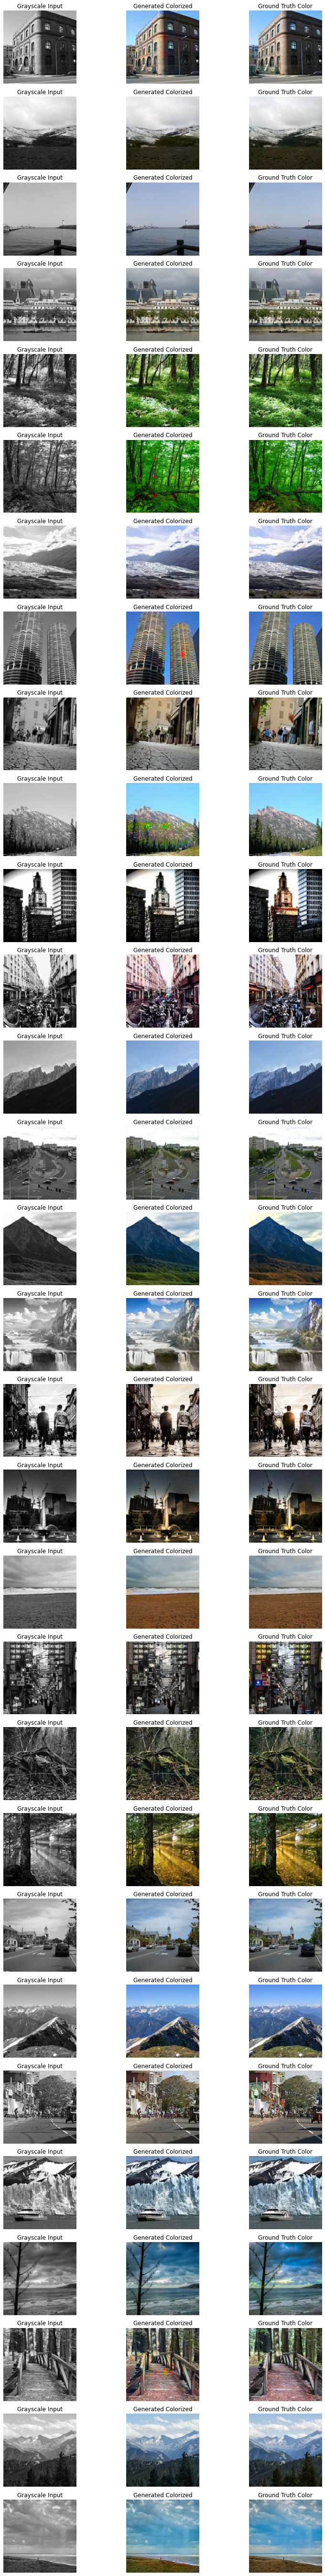

In [27]:
test_generator(generator, test_ds, num_samples=30)

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def test_single_image(generator, image_path):

    img = Image.open(image_path).convert("L")
    original_size = img.size
    img_resized = img.resize((256, 256), Image.LANCZOS)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=-1)       
    input_tensor = np.expand_dims(img_array, axis=0)    
    generated = generator(input_tensor, training=False)[0]
    generated = tf.clip_by_value(generated, 0.0, 1.0).numpy()

    gen_img = Image.fromarray((generated * 255).astype(np.uint8)).resize(original_size, Image.LANCZOS)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Grayscale Input")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(gen_img)
    plt.title("Generated Colorized")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


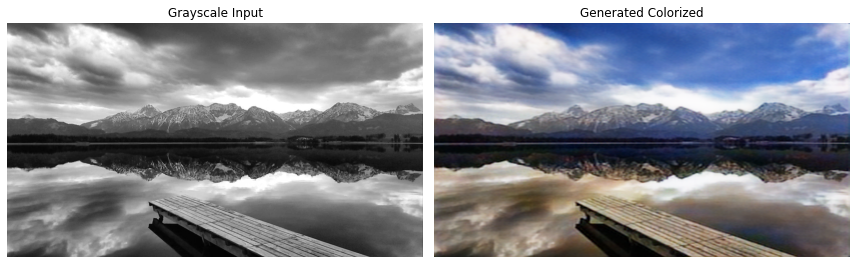

In [33]:
test_single_image(generator, "D:\\Job\\colorizationimage_code\\examples\\photo_4_2025-05-19_23-53-52.jpg")
